In [3]:
!pip install -q /kaggle/input/mtcnn-package/mtcnn-0.1.0-py3-none-any.whl

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import numpy as np
from numpy import savetxt
import pandas as pd
import os
from time import time
import cv2 #use OpenCV package
face_cascade = cv2.CascadeClassifier('/kaggle/input/haarcascades/haarcascade_frontalface_default.xml')
from tqdm.notebook import tqdm
from mtcnn import MTCNN
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import random
import copy

In [5]:
INPUT_PATH = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/'
metadata = pd.read_json(os.path.join(INPUT_PATH, 'metadata.json')).T
#EXTRACT_NOISE = True
WINDOW = 224
FACE_CONFIDENCE = .8
#FRAMES_PER_VIDEO = 1
#NOISE_DEPTH = 1

In [6]:
metadata.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [7]:
FILES = metadata.index
LABELS = metadata.label
print(FILES[0])

aagfhgtpmv.mp4


### Experiment on function ***extract_face()***

Take an image for trial

In [8]:
#try on image
fn = FILES[0]
video_path = os.path.join(INPUT_PATH, fn)
vidcap = cv2.VideoCapture(video_path)
success, image = vidcap.read()
im = image.copy()
im.shape

(1080, 1920, 3)

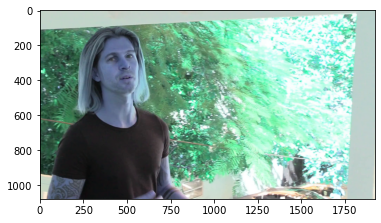

In [9]:
plt.imshow(im)

In [10]:
#input is unstandardized image, output is face with standard size
#这里有个问题就是如果视频中有两张脸，这个函数只会提取一张脸；如果没有脸，会返回背景截图；如果提取不到脸，就会返回空值
#这个函数需要被改进
def extract_face(frame):
    face_rects = face_cascade.detectMultiScale(frame,scaleFactor=1.3, minNeighbors=5)
    if len(face_rects)==0:
        roi = np.empty((100,100,3))
        roi[:]=np.nan
        return roi
    for (x,y,w,h) in face_rects: 
        roi = frame[y:y+h,x:x+w] 
    std_roi=cv2.resize(roi, (100,100), interpolation=cv2.INTER_AREA)
    return std_roi

(100, 100, 3)


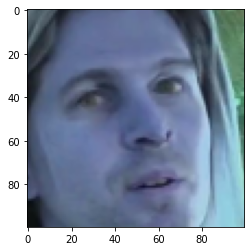

In [11]:
a = extract_face(im)
print(a.shape)
plt.imshow(a)

### Experiment on function ***crop_faces()***: extract face of every frame (one video with at most 20 frames)

In [12]:
%matplotlib inline
#input is 1 filename, output is faces crop of size cnt_limit*(100,100,3)
#if there's not enough faces to capture, it will return np.empty((20,100,100,3))
def crop_faces(fn,cnt_limit=20, plot=False, itr_limit = 250):
    faces=[]
    video_path = os.path.join(INPUT_PATH, fn)
    vidcap = cv2.VideoCapture(video_path)
    #fps = round(vidcap.get(cv2.CAP_PROP_FPS)) #frames per second
    #detector = MTCNN()
    success, image = vidcap.read() #sucess=True, image=matrix of numbers of size (1080, 1920, 3)
    count = 0
    itr = 0
    empty_faces = np.empty((20,100,100,3));empty_faces[:]=np.nan;
    while success:
        #if go beyond iterations limit, end loop
        itr+=1
        if itr>=itr_limit and count<cnt_limit*5:
            ##print("return empty")
            return empty_faces
        #every 5 frames, store captured face; if no face, continue capturing but don't add "count"
        if count%5 ==0:
            ##print("count:",count)
            face = extract_face(image) #crop the face in frame as size (100,100,3)
            if np.isnan(face).any():
                success,image = vidcap.read()
                ##print("no face"," count:",count)
                continue #if there's no face captured, then go to capture next face and not running count+=1
            else:
                faces.append(face)
                #plot captured faces
                if plot:
                    plt.figure(figsize=(80,80))
                    plt.subplot(cnt_limit,1,count/5+1)
                    plt.title(str(count))
                    plt.axis('off')
                    plt.imshow(face)
                    ##print('Read a new frame: ', success)
        success,image = vidcap.read()
        count += 1
        if count >=cnt_limit*5:
            break
    if len(faces)<cnt_limit:
        return empty_faces
    return np.asarray(faces)

In [13]:
fn = FILES[2]

frames size: (20, 100, 100, 3)


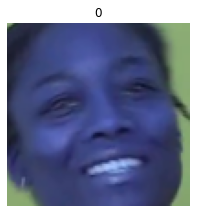

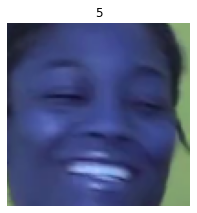

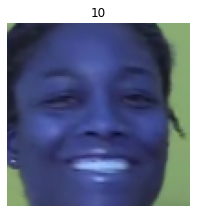

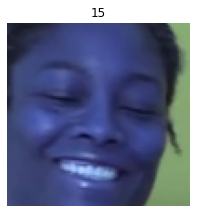

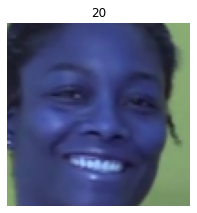

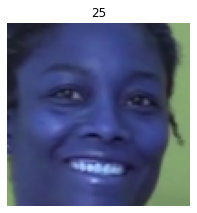

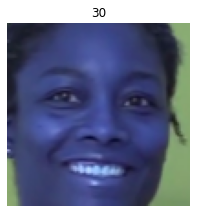

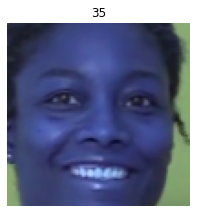

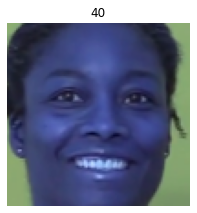

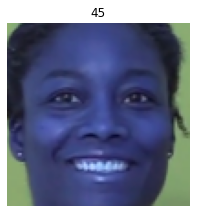

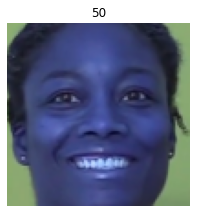

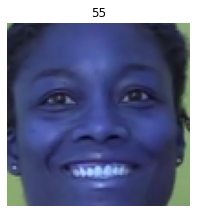

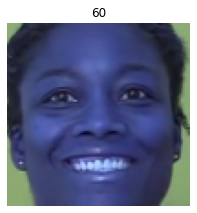

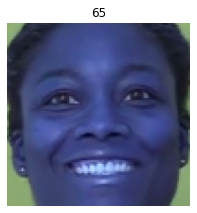

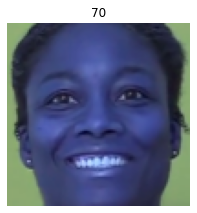

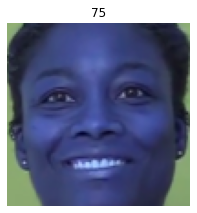

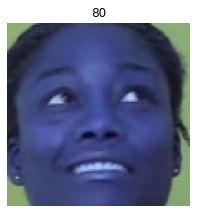

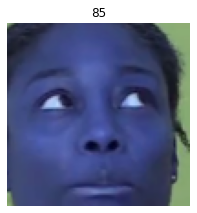

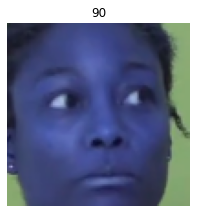

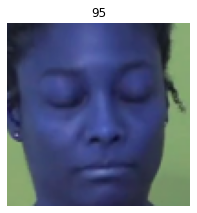

In [14]:
frames = crop_faces(fn,plot=True)
print("frames size:",frames.shape) #frame size is (cnt_limit=20,100,100,3)

In [15]:
frames.shape

(20, 100, 100, 3)

In [16]:
np.isnan(frames).any()

False

### Experiment on function ***face_noise()***: compute the noise df of face crop

In [17]:
# input is 1 image of face (size=(100,100,3)), output is noise df of the image (size=(100,100))
def face_noise(img, NOISE_DEPTH=1):
    if np.isnan(img).any():
        empty_sf = np.empty((100,100))
        empty_sf[:]=np.nan
        return empty_sf
    else:
        img1 = img - cv2.GaussianBlur(img, (3,3), 0)
        imgs1 = np.sum(img1, axis=2)
        if NOISE_DEPTH == 1:
            sf = np.fft.fftshift(np.fft.fft2(imgs1))
            eps = np.max(sf) * 1e-2
            s1 = np.log(sf + eps) - np.log(eps) 
            sf = (s1 * 255 / np.max(s1))
            sf = np.abs(sf)
        else:
            sf = np.stack([
                 np.fft.fftshift(np.fft.fft2( imgs1 )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,0] - img1[:,:,1] )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,1] - img1[:,:,2] )),
                 np.fft.fftshift(np.fft.fft2( img1[:,:,2] - img1[:,:,0] ))],
                 axis=-1)
            sf = np.abs(sf)
            nchans = sf.shape[2]
            for c in range(nchans):
                eps = np.max(sf[:,:,c]) * 1e-2
                s1 = np.log(sf[:,:,c] + eps) - np.log(eps) 
                sf[:, :, c] = (s1 * 255 / np.max(s1))
        return sf.astype(np.float16)

In [18]:
img = frames[0]
print("original shape:",img.shape)
a = face_noise(img)
print("noise_df shape:",a.shape)

original shape: (100, 100, 3)
noise_df shape: (100, 100)


Gaussian Blur to compute the noise... 

This is a plot of comparison between original image and Gaussian Blurred Vesion, and the noise is the difference between these two pictures.

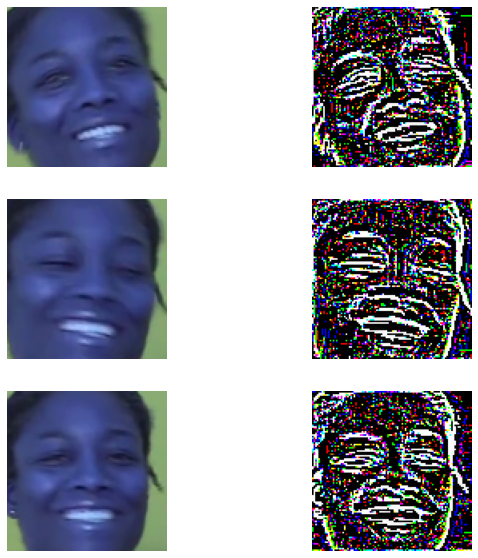

In [19]:
%matplotlib inline
w=3
h=2
fig=plt.figure(figsize=(10, 10))
columns = 2
rows = 3
for i in range(1, rows+1):
    img = frames[i-1]
    fig.add_subplot(rows, columns, columns*i-1)
    plt.imshow(img)
    plt.axis('off')
    img1 = img - cv2.GaussianBlur(img, (3,3), 0)
    fig.add_subplot(rows, columns, columns*i)
    plt.imshow(img1)
    plt.axis('off')
plt.show()

### Build the imput df with function ***build_features()***: every video becomes an input matrix of (20,100,100)

 every single video corresponds to a matrix of size (20,100,100), where 20 is the number of frames in each video, (100,100) is the noise matrix which sums up the 3-d RGB colors.

In [20]:
#input is 1 filename, output is noise array for that video, and its size=(20,100,100)
def build_features(f):
    frames = crop_faces(f,plot=False)
    if np.isnan(frames).any():
        empty_noise = np.empty((20,100,100))
        empty_noise[:]=np.nan
        return empty_noise
    #print("filename:",file,"frames size:",frames.shape)
    noise = np.array(list(map(face_noise,frames))) #map function to every frame; noise is of (20,100,100) for each video
    return noise

In [21]:
a = build_features(FILES[3])

In [22]:
a.shape

(20, 100, 100)

## Pre-trained features

In [ ]:
"""
%%time

tqdm.pandas()

for n in range(1,5):

    gap = int(len(FILES)/4)
    
    if n<4:
    
        FILES_store = FILES[range((n-1)*gap,n*gap+1)]
        
    else:
    
        FILES_store = FILES[(n-1)*gap:]
        
    all_video_fn = np.array(list(tqdm(map(build_features,FILES_store),
                         total=len(FILES_store), desc='Build Feature Set over FILES')))
                         
    np.save("video"+str(n)+".npy", all_video_fn)
    
    print("video"+str(n)+".npy"+" Complete!")
"""

In [164]:
tqdm.pandas()
n=4
gap = int(len(FILES)/4)
if n<4:
    FILES_store = FILES[range((n-1)*gap,n*gap)]
else:
    FILES_store = FILES[(n-1)*gap:]
all_video_fn = np.array(list(tqdm(map(build_features,FILES_store),
                     total=len(FILES_store), desc='Build Feature Set over FILES')))
np.save("video"+str(n)+".npy", all_video_fn)
print("video"+str(n)+".npy"+" Complete!")


video4.npy Complete!


Load pre-trained features for each picture, and combine them with labels

In [182]:
ar_1 = np.load('/kaggle/input/pre-trained-features/video1.npy')
ar_2 = np.load('/kaggle/input/pre-trained-features/video2.npy')
ar_3 = np.load('/kaggle/input/pre-trained-features/video3.npy')
ar_4 = np.load('/kaggle/input/pre-trained-features/video4.npy')
print(ar_1.shape)
print(ar_2.shape)
print(ar_3.shape)
print(ar_4.shape)

(100, 20, 100, 100)
(100, 20, 100, 100)
(100, 20, 100, 100)
(100, 20, 100, 100)


Obtain Feature Set and LABELS

In [183]:
feature_set = np.concatenate((ar_1, ar_2, ar_3, ar_4))
##print(feature_set[0,:,:,:])
#convert strings ('REAL'/'FAKE') into int(1/0)
labels_set = np.array(LABELS[0:feature_set.shape[0]])
pos = np.where(labels_set=='REAL') #pos[0] is the indices of 'REAL' label
labels_set = np.zeros(shape=(feature_set.shape[0],1))
labels_set[pos[0],0]=1
print(labels_set[0:5,:])

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [311]:
#eliminate positions with np.nan values
all_pos=[]; real_pos=[]; fake_pos=[];
for i in range(0,feature_set.shape[0]):
    a = np.isnan(feature_set[i,:,:,:]).any()
    if not a:
        all_pos.append(i)
        if i in pos[0]:
            real_pos.append(i)
        else:
            fake_pos.append(i)
print(feature_set.shape[0]-len(all_pos),"videos are dropped out of",feature_set.shape[0])
print("real videos:",len(real_pos))
print("fake videos:",len(fake_pos))

79 videos are dropped out of 400
real videos: 63
fake videos: 258


In [312]:
random.shuffle(real_pos)
random.shuffle(fake_pos)

Therefore, to balance the labels, we need to upsampling real_videos for 4 times

### split training set and test set

In [326]:
training_ix = real_pos[0:int(len(real_pos)*0.5+1)]*4+fake_pos[0:int(len(fake_pos)*0.7+1)]
remain_real_pos = [j for j in real_pos if j not in training_ix]
remain_fake_pos = [j for j in fake_pos if j not in training_ix]
test_ix = remain_real_pos+remain_fake_pos
##
random.shuffle(training_ix)
random.shuffle(test_ix)
X_train = feature_set[training_ix,:,:,:]
y_train = labels_set[training_ix,:]
X_test = feature_set[test_ix,:,:,:]
y_test = labels_set[test_ix,:]

In [327]:
print("label <real> in train set:",len(y_train[y_train==1]))
print("label <real> in test set:",len(y_test[y_test==1]))

label <real> in train set: 128
label <real> in test set: 31


In [328]:
print("X_train:",X_train.shape)
print("y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("y_test:",y_test.shape)

X_train: (309, 20, 100, 100)
y_train: (309, 1)
X_test: (108, 20, 100, 100)
y_test: (108, 1)


In [135]:
from keras.models import Sequential
from keras.layers import Dense, GRU, Bidirectional
import tensorflow.keras as tfk
from keras import layers
tfkl = tfk.layers
from keras.optimizers import SGD

In [332]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=3)]
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(16).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(16).prefetch(10)

## Build 3-d CNN

In [333]:
model = tfk.Sequential()

#Block 1
model.add(tfkl.Conv2D(filters = 20, kernel_size=(3,3), strides=(3,3), 
                      padding="valid", activation='tanh', input_shape=(20, 100, 100))) #smooth stride; padding: handle edges;
model.add(tfkl.MaxPool2D(pool_size=(1,2)))

#Block 2
model.add(tfkl.Conv2D(filters = 16, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
#model.add(tfkl.MaxPool2D(pool_size=2))
#model.add(tfkl.Dropout(.2))

#Block 3
model.add(tfkl.Conv2D(filters = 8, kernel_size=2, strides=1, 
                      padding="valid", activation='relu')) #smooth stride; padding: handle edges;
#model.add(tfkl.MaxPool2D(pool_size=2))

#Flatten
model.add(tfkl.GlobalMaxPool2D())
model.add(tfkl.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 6, 33, 20)         18020     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 6, 16, 20)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 5, 15, 16)         1296      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 4, 14, 8)          520       
_________________________________________________________________
global_max_pooling2d_13 (Glo (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 19,845
Trainable params: 19,845
Non-trainable params: 0
_________________________________________________

In [334]:
model.compile(
    optimizer=tfk.optimizers.RMSprop(), ##SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False)
    loss=tfk.losses.BinaryCrossentropy(),
    metrics=["acc"]
)

In [335]:
results = model.fit(ds_train, steps_per_epoch=10,epochs=20,
                    callbacks=cbs,verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/20
10/10 [==============================] - 1s 53ms/step - loss: 0.8383 - acc: 0.5000 - val_loss: 0.6915 - val_acc: 0.6875
Epoch 2/20
10/10 [==============================] - 0s 35ms/step - loss: 0.6927 - acc: 0.5503 - val_loss: 0.6908 - val_acc: 0.6875
Epoch 3/20
10/10 [==============================] - 0s 35ms/step - loss: 0.6805 - acc: 0.6062 - val_loss: 0.6351 - val_acc: 0.6875
Epoch 4/20
10/10 [==============================] - 0s 35ms/step - loss: 0.6934 - acc: 0.5638 - val_loss: 0.6417 - val_acc: 0.6875
Epoch 5/20
10/10 [==============================] - 0s 39ms/step - loss: 0.6795 - acc: 0.6062 - val_loss: 0.6431 - val_acc: 0.6875
Epoch 6/20
10/10 [==============================] - 1s 53ms/step - loss: 0.6989 - acc: 0.4899 - val_loss: 0.6523 - val_acc: 0.6875


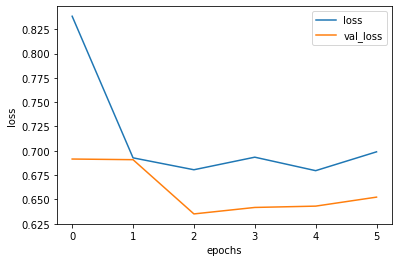

In [336]:
plt.plot(results.history["loss"])
plt.plot(results.history["val_loss"])
plt.legend(labels=["loss", "val_loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Build GRU

In [369]:
print(feature_set[all_pos].shape)
print(labels_set[all_pos].shape)

(321, 20, 100, 100)
(321, 1)


In [343]:
print(X_train.shape)
print(X_test.shape)

(309, 20, 100, 100)
(108, 20, 100, 100)


In [353]:
xx_train = X_train.reshape(309,20,10000,1)
xx_train = np.ndarray.mean(xx_train,axis=2)
print(xx_train.shape)
xx_test = X_test.reshape(108,20,10000,1)
xx_test = np.ndarray.mean(xx_test,axis=2)
print(xx_test.shape)

(309, 20, 1)
(108, 20, 1)


In [373]:
gru_feature_set = feature_set[all_pos].reshape(321,20,10000,1)
gru_feature_set = np.ndarray.mean(gru_feature_set,axis=2)
print(gru_feature_set.shape)
gru_labels_set = labels_set[all_pos]
print(gru_labels_set.shape)

(321, 20, 1)
(321, 1)


In [357]:
#cbs = [tfk.callbacks.EarlyStopping(min_delta=0.001,patience=3)]
gru_ds_train = tf.data.Dataset.from_tensor_slices((xx_train,y_train)).batch(16).repeat().prefetch(10) 
gru_ds_test = tf.data.Dataset.from_tensor_slices((xx_test,y_test)).batch(16).prefetch(10)

In [372]:
# The GRU architecture
GRU_mod = Sequential()
# First GRU layer with Dropout regularisation
GRU_mod.add(GRU(units=20, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Second GRU layer
GRU_mod.add(GRU(units=50, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Third GRU layer
GRU_mod.add(GRU(units=30, return_sequences=True, input_shape=(xx_train.shape[1],1), activation='tanh'))
GRU_mod.add(Dropout(0.2))
# Fourth GRU layer
GRU_mod.add(GRU(units=10, activation='tanh'))
GRU_mod.add(Dropout(0.2))
# The output layer
GRU_mod.add(Dense(units=1,activation='sigmoid'))
GRU_mod.summary()


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 20, 20)            1380      
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 20)            0         
_________________________________________________________________
gru_26 (GRU)                 (None, 20, 50)            10800     
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 50)            0         
_________________________________________________________________
gru_27 (GRU)                 (None, 20, 30)            7380      
_________________________________________________________________
dropout_27 (Dropout)         (None, 20, 30)            0         
_________________________________________________________________
gru_28 (GRU)                 (None, 10)              

In [362]:
GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output =  GRU_mod.fit(xx_train,y_train,epochs=50,batch_size=16)
#output = GRU_mod.fit(gru_ds_train, steps_per_epoch=10,epochs=20,
#                    verbose=1,validation_data=gru_ds_test,validation_steps=1)

Epoch 1/50
20/20 [==============================] - 1s 40ms/step - loss: 0.6938 - acc: 0.5631
Epoch 2/50
20/20 [==============================] - 1s 40ms/step - loss: 0.6884 - acc: 0.5049
Epoch 3/50
20/20 [==============================] - 1s 39ms/step - loss: 0.7141 - acc: 0.5599
Epoch 4/50
20/20 [==============================] - 1s 46ms/step - loss: 0.6970 - acc: 0.5922
Epoch 5/50
20/20 [==============================] - 1s 46ms/step - loss: 0.6791 - acc: 0.5858
Epoch 6/50
20/20 [==============================] - 1s 47ms/step - loss: 0.6850 - acc: 0.5631
Epoch 7/50
20/20 [==============================] - 1s 44ms/step - loss: 0.6879 - acc: 0.5858
Epoch 8/50
20/20 [==============================] - 1s 44ms/step - loss: 0.6808 - acc: 0.5825
Epoch 9/50
20/20 [==============================] - 1s 51ms/step - loss: 0.6804 - acc: 0.5631
Epoch 10/50
20/20 [==============================] - 1s 40ms/step - loss: 0.6921 - acc: 0.5793
Epoch 11/50
20/20 [==============================] - 1s 41m

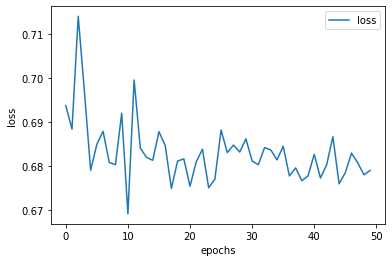

In [364]:
plt.plot(output.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [374]:
GRU_mod.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),
                     loss=tfk.losses.BinaryCrossentropy(),metrics=["acc"])
output =  GRU_mod.fit(gru_feature_set,gru_labels_set,epochs=50,batch_size=16)
#output = GRU_mod.fit(gru_ds_train, steps_per_epoch=10,epochs=20,
#                    verbose=1,validation_data=gru_ds_test,validation_steps=1)

Epoch 1/50
21/21 [==============================] - 1s 41ms/step - loss: 0.5642 - acc: 0.7072
Epoch 2/50
21/21 [==============================] - 1s 43ms/step - loss: 0.5186 - acc: 0.8037
Epoch 3/50
21/21 [==============================] - 1s 40ms/step - loss: 0.5146 - acc: 0.8037
Epoch 4/50
21/21 [==============================] - 1s 40ms/step - loss: 0.5226 - acc: 0.8037
Epoch 5/50
21/21 [==============================] - 1s 44ms/step - loss: 0.4955 - acc: 0.8037
Epoch 6/50
21/21 [==============================] - 1s 48ms/step - loss: 0.4996 - acc: 0.8037
Epoch 7/50
21/21 [==============================] - 1s 44ms/step - loss: 0.5047 - acc: 0.8037
Epoch 8/50
21/21 [==============================] - 1s 53ms/step - loss: 0.5100 - acc: 0.8037
Epoch 9/50
21/21 [==============================] - 1s 42ms/step - loss: 0.5065 - acc: 0.8037
Epoch 10/50
21/21 [==============================] - 1s 42ms/step - loss: 0.5069 - acc: 0.8037
Epoch 11/50
21/21 [==============================] - 1s 41m

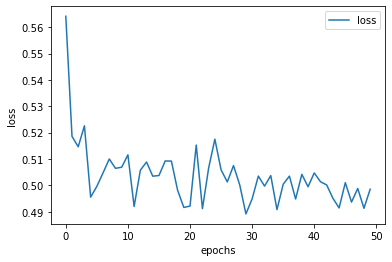

In [375]:
plt.plot(output.history["loss"])
plt.legend(labels=["loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Reference:
https://www.kaggle.com/pathofdata/dpn50
https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru